# Classification Validation

## Accuracy assessment metrics

We will use functions from the `sklearn.metrics` module to evaluate the k-means clustering classification. 
Accuracy is used when the True Positives and True negatives are more important while F1-score is used when the False Negatives and False Positives are crucial. 

$$
\begin{aligned}
\text{Overall Accuracy (OA)} = \frac{\text{True Positive} + \text{True Negative}}{\text{Total Pixels}}
\end{aligned}
$$

$$
\begin{aligned}
\text{Producer's Accuracy (PA) or Precision} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Positive}}
\end{aligned}
$$

$$
\begin{aligned}
\text{User's accuracy (UA) or  Recall} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Negative}}
\end{aligned}
$$

$$
\begin{aligned}
\text{F1 Score} = 2*\frac{\text{Recall}*\text{Precision}}{\text{Recall} + \text{Precision}}
\end{aligned}
$$


***
## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load Packages

In [1]:
import datacube
import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rio
import xarray as xr
from datacube.testutils.io import rio_slurp_xarray
from datacube.utils.cog import write_cog
from datacube.utils.masking import mask_invalid_data
from deafrica_tools.classification import sklearn_flatten, sklearn_unflatten
from deafrica_tools.plotting import display_map, plot_lulc
from matplotlib import colors as mcolors
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="validation")

### Analysis Parameters

* `pred_tif`: The path and name of the prediction GeoTIFF output in the previous notebook.
* `ouput_dir`: A folder location to store the classified GeoTIFFs.

In [3]:
year = "2017"
output_dir = "results"

pred_tif = f"{output_dir}/prediction_{year}.tif"

# Coordinates for the classified area from 4_Classify_satellite_data.ipynb
new_lat, new_lon = 1.3733, 32.2903 #centred on Uganda
buf_lat, buf_lon = 1, 1


class_dict = {
    "Cropland": 1,
    "Dense Forest": 2,
    "Open Forest": 3,
    "Open Grassland": 4,
    "Open Water": 5,
    "Otherland": 6,
    "Settlements": 7,
    "Vegetated Wetland": 8,
    "Wooded Grassland": 9,
}

## Validation using Copernicus Global Land Service Global Land Cover at 100m spatial resolution

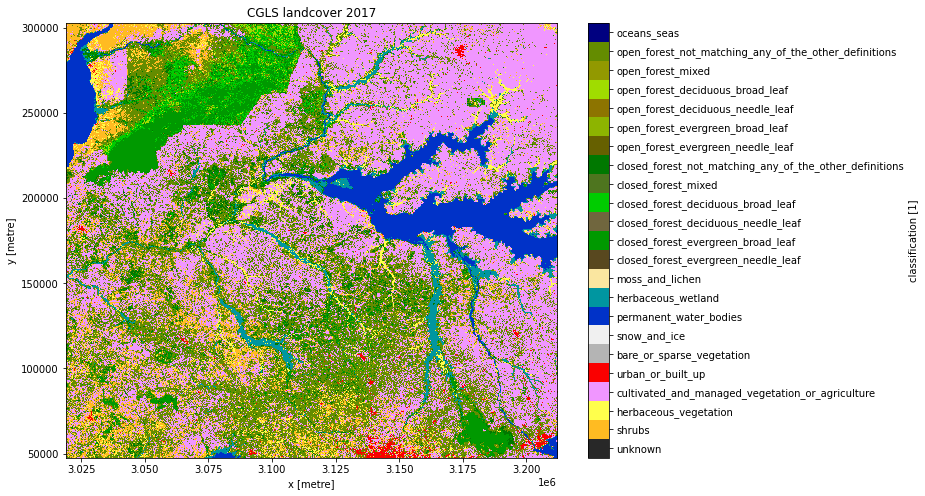

In [4]:
# load the CGLS product.
ds_cgls = dc.load(
    product="cgls_landcover",
    time=year,
    x=(new_lon - buf_lon, new_lon + buf_lon),
    y=(new_lat + buf_lat, new_lat - buf_lat),
    measurements="classification",
    resolution=(100, -100),
    output_crs="epsg:6933").classification.squeeze()

## Plot the CGLS product.
plot_lulc(ds_cgls, product="CGLS", legend=True, figsize=(11, 8))
plt.title(f"CGLS landcover {year}");

In [5]:
# Mask the CGLS product to retain only pixels representing vegetated wetlands.
# 90 herbaceous wetland
veg_wetland_cgls = xr.where((ds_cgls == 90), 1, 0)

In [6]:
# Load the  pixel-based prediction raster and reproject to match 'ds_cgls'.
pred = rio_slurp_xarray(fname=pred_tif, gbox=ds_cgls.geobox, resampling="nearest")

# Mask the dataset to create a binary classification image where 0 is non-vegetated wetland and 1 is vegetated wetland.
veg_wetland_pred = xr.where(pred == 8, 1, 0)

# Convert the 'veg_wetland_pred' DataArray into a 2 dimensional numpy array.
y_pred = sklearn_flatten(veg_wetland_pred)

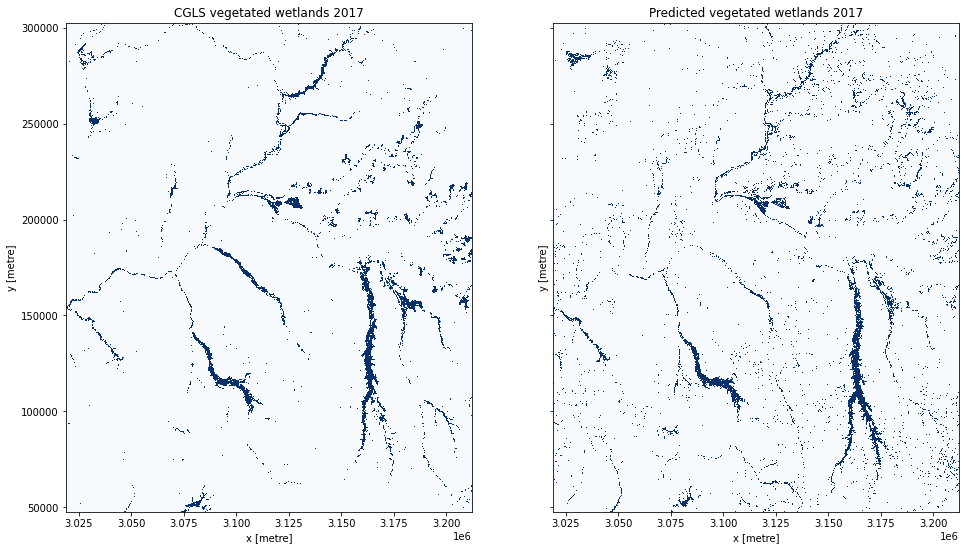

In [7]:
# Plot the vegetated wetland from `ds_cgls` and the prediction image.
fig, ax = plt.subplots(1, 2, figsize=(16, 9), sharey=True)
veg_wetland_cgls.plot.imshow(cmap="Blues", ax=ax[0], add_colorbar=False)
veg_wetland_pred.plot(cmap="Blues", ax=ax[1], add_colorbar=False)
ax[0].set_title(f"CGLS vegetated wetlands {year}")
ax[1].set_title(f"Predicted vegetated wetlands {year}");

In [8]:
# Convert the 'veg_wetland_cgls' DataArray into a 2 dimensional numpy array.
y_true = sklearn_flatten(veg_wetland_cgls)

# Compare the predicted image and the CGLS product.
# Overall Accuracy.
oa = accuracy_score(y_true, y_pred, normalize=True) * 100

# Producer's Accuracies.
pa = precision_score(y_true, y_pred, average=None)[1] * 100

# User's Accuracies.
ua = recall_score(y_true, y_pred, average=None)[1] * 100

# F1 score.
f1score = f1_score(y_true, y_pred, average="micro")


print(
    "\033[1m" + "\033[91m" + f"Vegetated wetlands {year} (validation using CGLS)"
)  # bold print and red
print("\033[0m")  # stop bold and red
print("Overall Accuracy: ", round(oa, 2))
print("Producer's Accuracy: ", round(pa, 2))
print(
    "User's Accuracy: ",
    round(ua, 2),
)
print("F1 score: \t", round(f1score, 2))

Vegetated wetlands 2017 (validation using CGLS)

Overall Accuracy:  96.31
Producer's Accuracy:  42.69
User's Accuracy:  55.8
F1 score: 	 0.96


## Validation using ESA Climate Change Initiative Land Cover at 300m spatial resolution

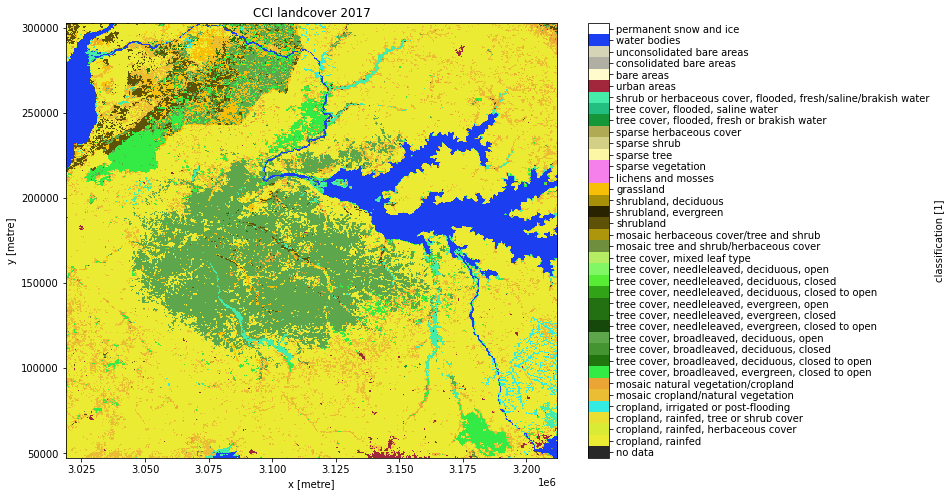

In [9]:
# Load the CCI product.
ds_cci = dc.load(
    product="cci_landcover",
    time=year,
    x=(new_lon - buf_lon, new_lon + buf_lon),
    y=(new_lat + buf_lat, new_lat - buf_lat),
    measurements="classification",
    resolution=(300, -300),
    output_crs="epsg:6933").classification.squeeze()

## Plot the CCI product.
plot_lulc(ds_cci, product="CCI", legend=True, figsize=(11, 8))
plt.title(f"CCI landcover {year}");

In [10]:
# Mask the CCI product to retain only pixels representing vegetated wetlands.
# 160 tree cover, flooded, fresh or brakish water
# 170 tree cover, flooded, saline water
# 180 shrub or herbaceous cover, flooded, fresh/saline/brakish water
veg_wetland_cci = xr.where((ds_cci == 160) | (ds_cci == 170)| (ds_cci == 180), 1, 0)

In [11]:
# Load the  pixel-based prediction raster and reproject to match 'ds_cci'.
pred = rio_slurp_xarray(fname=pred_tif, gbox=ds_cci.geobox, resampling="nearest")

# Mask the dataset to create a binary classification image where 0 is non-vegetated wetland and 1 is vegetated wetland.
veg_wetland_pred = xr.where(pred == 8, 1, 0)

# Convert the 'veg_wetland_pred' DataArray into a 2 dimensional numpy array.
y_pred = sklearn_flatten(veg_wetland_pred)

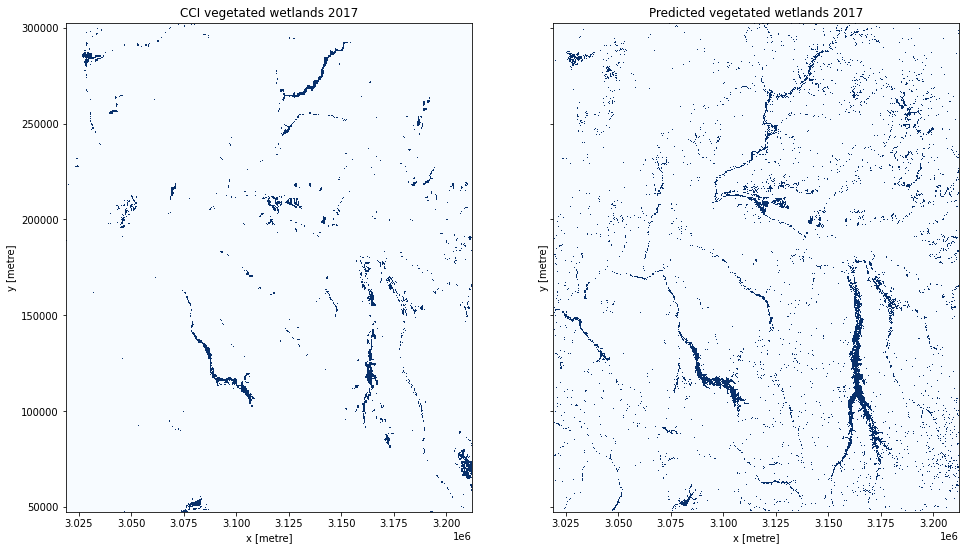

In [12]:
# Plot the vegetated wetland from `ds_cci` and the prediction image.
fig, ax = plt.subplots(1, 2, figsize=(16, 9), sharey=True)
veg_wetland_cci.plot.imshow(cmap="Blues", ax=ax[0], add_colorbar=False)
veg_wetland_pred.plot(cmap="Blues", ax=ax[1], add_colorbar=False)
ax[0].set_title(f"CCI vegetated wetlands {year}")
ax[1].set_title(f"Predicted vegetated wetlands {year}");

In [13]:
# Convert the 'veg_wetland_cci' DataArray into a 2 dimensional numpy array.
y_true = sklearn_flatten(veg_wetland_cci)

# Compare the predicted image and the CCI product.
# Overall Accuracy.
oa = accuracy_score(y_true, y_pred, normalize=True) * 100

# Producer's Accuracies.
pa = precision_score(y_true, y_pred, average=None)[1] * 100

# User's Accuracies.
ua = recall_score(y_true, y_pred, average=None)[1] * 100

# F1 score.
f1score = f1_score(y_true, y_pred, average="micro")


print(
    "\033[1m" + "\033[91m" + f"Vegetated wetlands {year} (validation using CCI)"
)  # bold print and red
print("\033[0m")  # stop bold and red
print("Overall Accuracy: ", round(oa, 2))
print("Producer's Accuracy: ", round(pa, 2))
print(
    "User's Accuracy: ",
    round(ua, 2),
)
print("F1 score: \t", round(f1score, 2))

Vegetated wetlands 2017 (validation using CCI)

Overall Accuracy:  96.16
Producer's Accuracy:  22.14
User's Accuracy:  55.17
F1 score: 	 0.96


## Validation using the Global Lakes and Wetlands Database Level 3 Dataset

In [14]:
# Open the Global Lakes and Wetlands Database Level 3 
# GLWD-3 comprises lakes, reservoirs, rivers and different wetland types in the form of a global raster map at 30-second resolution. 
# From https://www.worldwildlife.org/publications/global-lakes-and-wetlands-database-lakes-and-wetlands-grid-level-3

# Load raster
ds_glwd = rio.open_rasterio("data/validation_data/GLWD_3.tif").squeeze().drop_vars("band")

# Set nodata to `NaN`
ds_glwd = ds_glwd.where(ds_glwd != 255)

In [15]:
glwd_legend = {
    1: "Lake",
    2: "Reservoir",
    3: "River",
    4: "Freshwater Marsh, Floodplain",
    5: "Swamp Forest, Flooded Forest",
    6: "Coastal Wetland (incl. Mangrove, Estuary, Delta, Lagoon)",
    7: "Pan, Brackish/Saline Wetland",
    8: "Bog, Fen, Mire (Peatland)",
    9: "Intermittent Wetland/Lake",
    10: "50-100% Wetland",
    11: "25-50% Wetland",
    12: "Wetland Compex (0-25% Wetland)",
}

# Mask the GLWD DataArray to retain only pixels representing vegetated wetland.
veg_wetland_glwd = xr.where((ds_glwd > 3) & (ds_glwd < 11), 1 , 0)

In [16]:
# Load the  pixel-based prediction raster and reproject to match 'ds_glwd'.
pred = rio_slurp_xarray(fname=pred_tif, gbox=ds_glwd.geobox, resampling="nearest")

# Mask the dataset to create a binary classification image where 0 is non-vegetated wetland and 1 is vegetated wetland.
veg_wetland_pred = xr.where(pred == 8, 1, 0)

# Convert the 'veg_wetland_pred' DataArray into a 2 dimensional numpy array.
y_pred = sklearn_flatten(veg_wetland_pred)

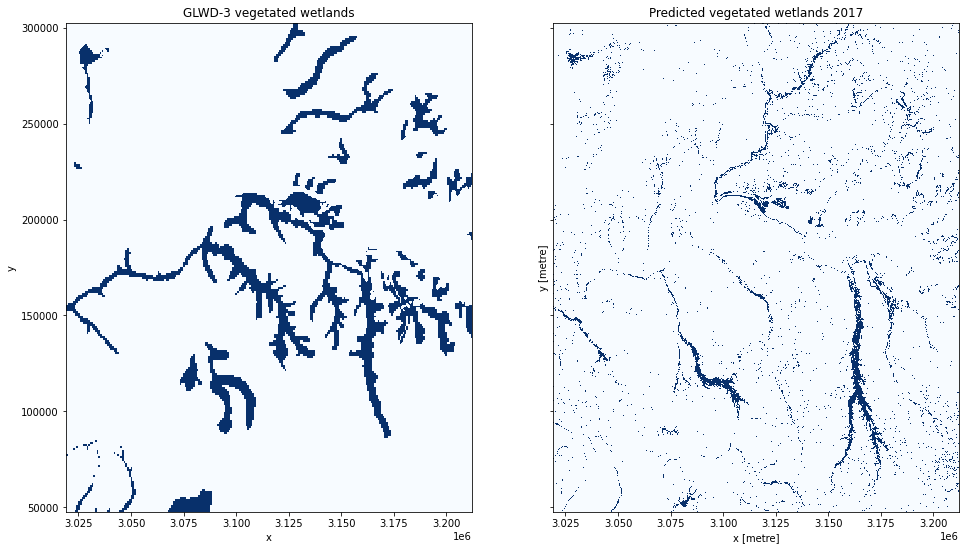

In [17]:
# Plot the vegetated wetland from `ds_glwd` and the prediction image.
fig, ax = plt.subplots(1, 2, figsize=(16, 9), sharey=True)
veg_wetland_glwd.plot.imshow(cmap="Blues", ax=ax[0], add_colorbar=False)
veg_wetland_pred.plot(cmap="Blues", ax=ax[1], add_colorbar=False)
ax[0].set_title(f"GLWD-3 vegetated wetlands")
ax[1].set_title(f"Predicted vegetated wetlands {year}");

In [18]:
# Convert the 'veg_wetland_glwd' DataArray into a 2 dimensional numpy array.
y_true = sklearn_flatten(veg_wetland_glwd)

# Compare the predicted image and the GLWD-3 product.
# Overall Accuracy.
oa = accuracy_score(y_true, y_pred, normalize=True) * 100

# Producer's Accuracies.
pa = precision_score(y_true, y_pred, average=None)[1] * 100

# User's Accuracies.
ua = recall_score(y_true, y_pred, average=None)[1] * 100

# F1 score.
f1score = f1_score(y_true, y_pred, average="micro")


print(
    "\033[1m" + "\033[91m" + f"Vegetated wetlands {year} (validation using GLWD-3)"
)  # bold print and red
print("\033[0m")  # stop bold and red
print("Overall Accuracy: ", round(oa, 2))
print("Producer's Accuracy: ", round(pa, 2))
print(
    "User's Accuracy: ",
    round(ua, 2),
)
print("F1 score: \t", round(f1score, 2))

Vegetated wetlands 2017 (validation using GLWD-3)

Overall Accuracy:  89.76
Producer's Accuracy:  41.67
User's Accuracy:  17.61
F1 score: 	 0.9


## Validation using the Global Tropical and Subtropical Wetlands Map

In [19]:
# Open the Global Tropical and Subtropical Wetlands Map version 7.0
# GTSW comprises lakes, reservoirs, rivers and different wetland types in the form of a global raster map at 30-second resolution. 
# From https://data.cifor.org/file.xhtml?fileId=4760&version=7.0

# Load raster
ds_gtswm = rio.open_rasterio("data/validation_data/GTSWM.tif").squeeze().drop_vars("band")

In [20]:
gtswm_legend = {
    10: "Open Water",
    20: "Mangroves",
    30: "Swamps/Bogs",
    40: "Fens",
    50: "Riverine/Lacustrine",
    60: "Floodout-swamps",
    70: "Floodplains and intermittent water bodies",
    80: "Marshes",
    90: "Wetland in arid climates",
    100: "Wet meadow",
}

# Mask the GTSWM DataArray to retain only pixels representing vegetated wetland.
veg_wetland_gtswm = xr.where((ds_gtswm > 10) , 1 , 0)

In [21]:
# Load the  pixel-based prediction raster and reproject to match 'ds_gtswm'.
pred = rio_slurp_xarray(fname=pred_tif, gbox=ds_gtswm.geobox, resampling="nearest")

# Mask the dataset to create a binary classification image where 0 is non-vegetated wetland and 1 is vegetated wetland.
veg_wetland_pred = xr.where(pred == 8, 1, 0)

# Convert the 'veg_wetland_pred' DataArray into a 2 dimensional numpy array.
y_pred = sklearn_flatten(veg_wetland_pred)

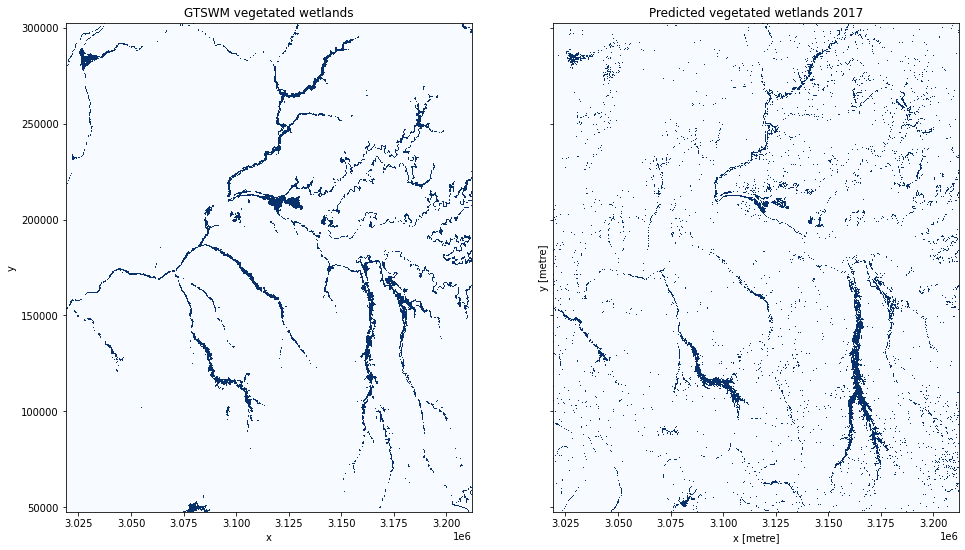

In [22]:
# Plot the vegetated wetland from `ds_gtswm` and the prediction image.
fig, ax = plt.subplots(1, 2, figsize=(16, 9), sharey=True)
veg_wetland_gtswm.plot.imshow(cmap="Blues", ax=ax[0], add_colorbar=False)
veg_wetland_pred.plot(cmap="Blues", ax=ax[1], add_colorbar=False)
ax[0].set_title(f"GTSWM vegetated wetlands")
ax[1].set_title(f"Predicted vegetated wetlands {year}");

In [23]:
# Convert the 'veg_wetland_gtswm' DataArray into a 2 dimensional numpy array.
y_true = sklearn_flatten(veg_wetland_gtswm)

# Compare the predicted image and the GTSWM product.
# Overall Accuracy.
oa = accuracy_score(y_true, y_pred, normalize=True) * 100

# Producer's Accuracies.
pa = precision_score(y_true, y_pred, average=None)[1] * 100

# User's Accuracies.
ua = recall_score(y_true, y_pred, average=None)[1] * 100

# F1 score.
f1score = f1_score(y_true, y_pred, average="micro")


print(
    "\033[1m" + "\033[91m" + f"Vegetated wetlands {year} (validation using GTSWM)"
)  # bold print and red
print("\033[0m")  # stop bold and red
print("Overall Accuracy: ", round(oa, 2))
print("Producer's Accuracy: ", round(pa, 2))
print(
    "User's Accuracy: ",
    round(ua, 2),
)
print("F1 score: \t", round(f1score, 2))

Vegetated wetlands 2017 (validation using GTSWM)

Overall Accuracy:  95.33
Producer's Accuracy:  40.23
User's Accuracy:  41.86
F1 score: 	 0.95
